1 A/B-тестирование
================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
groups = pd.read_csv('groups.csv', sep=';')
checks = pd.read_csv('checks.csv', sep=';')
active_studs = pd.read_csv('active_studs.csv', sep=';')

Подготовка данных
------------------------------

Сначала исследуем данные и проверим, нет ли в наших датафреймах "мусорных" значений.

In [2]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
id     74576 non-null int64
grp    74576 non-null object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [3]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
student_id    541 non-null int64
rev           541 non-null float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [4]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
student_id    8341 non-null int64
dtypes: int64(1)
memory usage: 65.3 KB


In [5]:
groups[groups['id'] < 0]

,id,grp


In [6]:
groups['grp'].unique()

array(['B', 'A'], dtype=object)

In [7]:
checks[checks['student_id'] < 0] 

,student_id,rev


In [8]:
checks[checks['rev'] < 0]

,student_id,rev


In [9]:
active_studs[active_studs['student_id'] < 0]

,student_id


Таким образом, нам достался чистый датасет. Теперь приведем данные в более удобную для нас форму.

In [10]:
groups.rename(columns = {'id':'student_id'}, inplace = True) # приведём таблицу к общему виду
data = active_studs.merge(groups, on='student_id', how='inner') # сджойним таблицы, схлопнув столбцы student_id
data = data.merge(checks, on='student_id', how='left') # джойним через left, т.к. в checks только платящие клиенты
data

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


В итоге имеем таблицу с 8341 наблюдением, как и изначально. Это означает, что в checks все id были уникальны и нам не надо суммировать несколько разных оплат для одного клиента. Заметим, что rev = NaN означет, что клиент не совершал покупку и прибыль с него равна нулю. Заменим NaN на 0. 

In [11]:
data['rev'].fillna(0, inplace=True)

Добавим новый столбец с информацией, своершил ли клиент покупку.

In [12]:
data['converted'] = (data['rev'] > 0).astype(int) # rev > 0, следовательно была совершена покупка
data

,student_id,grp,rev,converted
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


Первичный анализ эксперимента
----------------------

In [13]:
import altair as alt # библиотека для визуализации данных

alt.data_transformers.disable_max_rows()
alt.Chart(data).mark_bar().encode(
    alt.Y('grp', title='Group'),
    alt.X('count(student_id)', title='Number of Users'),
    color='grp'
)

alt.Chart(...)

В тестовой группе намного больше пользователей. Теперь проверим основные метрики - конверсию, ARPU и ARPPU.

In [14]:
alt.Chart(data).mark_bar().encode(
    alt.Y('grp', title='Group'),
    alt.X('average(converted)', title='Conversion Rate'), # конверсия будет равна среднему значению converted
    color='grp'
)

alt.Chart(...)

Как видим конверсия упала, однако мы еще не знаем, статистически значимы ли эти изменения. Возможно, это следствие большего числа пользователей в тестовой группе.

In [15]:
alt.Chart(data).mark_bar().encode(
    alt.Y('grp', title='Group'),
    alt.X('average(rev)', title='ARPU'),
    color='grp'
)

alt.Chart(...)

In [16]:
alt.Chart(data[data['converted'] == 1]).mark_bar().encode( # учитываем только наблюдения с платящими клиентами
    alt.Y('grp', title='Group'),
    alt.X('average(rev)', title='ARPPU'),
    color='grp'
)

alt.Chart(...)

Таким образом, ARPU и ARPPU выросли, несмотря на падение конверсии. Теперь проверим эти различия на статзначимость.

A/B тест
------------

Сначала выясним, статзначимо ли падение конверсии. Для этого воспользуемся z-тестом для пропорций. Пусть уровень значимости $\alpha = 0,05$.

In [17]:
from statsmodels.stats.proportion import proportions_ztest

control_results = data[data['grp'] == 'A']['converted']
test_results = data[data['grp'] == 'B']['converted']
successes = [control_results.sum(), test_results.sum()] # число успехов
nobs = [control_results.count(), test_results.count()] # число испытаний

z_stat, pval = proportions_ztest(successes, nobs=nobs)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')

z statistic: 0.76
p-value: 0.445


p значение очень большое, значит различия в конверсии не статзначимы. 

Теперь проверим статзначимость увеличения ARPPU с помощью критерия Манна-Уитни. Уровень занчимости по прежнему 0,05.

In [18]:
control_pay = data[data['grp'] == 'A'][data['rev'] > 0]
test_pay = data[data['grp'] == 'B'][data['rev'] > 0]

In [19]:
from scipy.stats import mannwhitneyu

u_stat, pval = mannwhitneyu(control_pay['rev'], test_pay['rev'])
print(f'U statistic: {u_stat:.2f}')
print(f'p-value: {pval:.5f}')

U statistic: 9001.00
p-value: 0.00013


Мы выяснили, что увеличение ARPPU статистически значимо, а падение конверсии нет. Исходя из этого, я полагаю,
что новую механику можно запускать на всех пользователей.

3 Python
=======

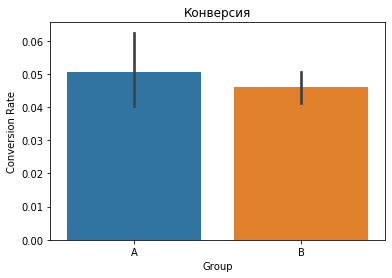

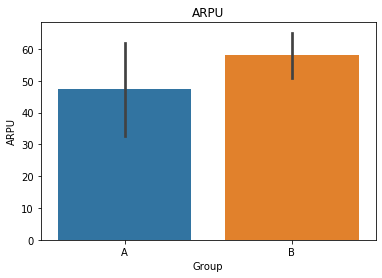

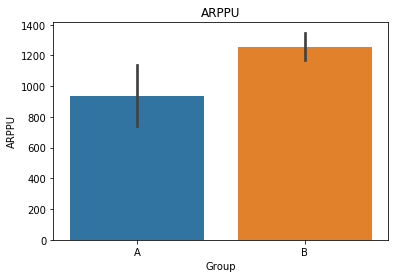

In [62]:
import seaborn as sns

def ab_test_results(groups, active_studs, checks):
    
    # мы уже проделали почти всё в прошлом задании, осталось только объединить это в одной функции
    
    groups.rename(columns = {'id':'student_id'}, inplace = True)
    data = active_studs.merge(groups, on='student_id', how='inner')
    data = data.merge(checks, on='student_id', how='left')
    data['rev'].fillna(0, inplace=True)
    data['converted'] = (data['rev'] > 0).astype(int)
    
    sns.barplot(data=data, x='grp', y='converted')
    plt.title('Конверсия')
    plt.xlabel('Group')
    plt.ylabel('Conversion Rate')
    plt.show()
    sns.barplot(data=data, x='grp', y='rev')
    plt.title('ARPU')
    plt.xlabel('Group')
    plt.ylabel('ARPU')
    plt.show()
    sns.barplot(data=data[data['rev'] > 0], x='grp', y='rev')
    plt.title('ARPPU')
    plt.xlabel('Group')
    plt.ylabel('ARPPU')
    plt.show()

ab_test_results(groups, active_studs, checks)